# Preliminaries: model definition and utilities

In [ ]:
import math
import torch
import torch.nn as nn
import random
import numpy as np
import torch.nn.functional as F
import argparse
import os
import shutil
import time
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Neural Network definitions

WideResNet from following [repo](https://github.com/xternalz/WideResNet-pytorch/blob/master/wideresnet.py)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]
        self.softmax = nn.Softmax()
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        out = self.fc(out)
        out = self.softmax(out)
        return out


In [ ]:
# simple conv network
# (argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number)
class NetSimple(nn.Module):
    def __init__(self, num_classes, width1 = 6, width2 = 16,ff_units1 = 120, ff_units2 = 84):
        super().__init__()
        self.conv1 = nn.Conv2d(3, width1, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(width1, width2, 5)
        self.fc1 = nn.Linear(width2 * 5 * 5, ff_units1)
        self.fc2 = nn.Linear(ff_units1, ff_units2)
        self.fc3 = nn.Linear(ff_units2, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x



In [ ]:
# simple conv network
# (argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number)
class NetComplex(nn.Module):
    def __init__(self, num_classes, width1 = 6, width2 = 16,ff_units1 = 120, ff_units2 = 84):
        super().__init__()
        self.conv1 = nn.Conv2d(3, width1, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(width1, width2, 5)
        self.conv3 = nn.Conv2d(width2, width2, 5)
        self.fc1 = nn.Linear(width2 * 3 * 3, ff_units1)
        self.fc2 = nn.Linear(ff_units1, ff_units2)
        self.fc3 = nn.Linear(ff_units2, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        to_print_size = False
        x = self.pool(F.relu(self.conv1(x)))
        if to_print_size:
            print(x.size())
        x = F.relu(self.conv2(x))
        if to_print_size:
            print(x.size())
        x = self.pool(F.relu(self.conv3(x)))
        if to_print_size:
            print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if to_print_size:
            print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x



# Metrics and utilities

In [ ]:
def reject_CrossEntropyLoss(outputs, m, labels, m2, n_classes):
    '''
    The L_{CE} loss implementation for CIFAR
    ----
    outputs: network outputs
    m: cost of deferring to expert cost of classifier predicting (I_{m =y})
    labels: target
    m2:  cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
    n_classes: number of classes
    '''
    batch_size = outputs.size()[0]  # batch_size
    rc = [n_classes] * batch_size
    outputs = -m * torch.log2(outputs[range(batch_size), rc] + 1e-12) - m2 * torch.log2(
        outputs[range(batch_size), labels] + 1e-12)  
    return torch.sum(outputs) / batch_size + 1e-12

def my_CrossEntropyLoss(outputs, labels):
    # Regular Cross entropy loss
    batch_size = outputs.size()[0]  # batch_size
    outputs = - torch.log2(outputs[range(batch_size), labels])  # regular CE
    return torch.sum(outputs) / batch_size


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res




def metrics_print(net, expert_fn, n_classes, loader):
    '''
    Computes metrics for deferal
    -----
    Arguments:
    net: model
    expert_fn: expert model
    n_classes: number of classes
    loader: data loader
    '''
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    alone_correct = 0
    correct_pred = {classname: 0 for classname in cifar_classes}
    total_pred = {classname: 0 for classname in cifar_classes}
    with torch.no_grad():
        for data in loader:
            images, labels, _, _ ,_ = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            batch_size = outputs.size()[0]  # batch_size
            exp_prediction = expert_fn(images, labels)
            for i in range(0, batch_size):
                r = (predicted[i].item() == n_classes)
                prediction = predicted[i]
                final_pred = 0
                if predicted[i] == n_classes:
                    max_idx = 0
                    # get second max
                    for j in range(0, n_classes):
                        if outputs.data[i][j] >= outputs.data[i][max_idx]:
                            max_idx = j
                    prediction = max_idx
                else:
                    prediction = predicted[i]
                alone_correct += (prediction == labels[i]).item()
                if r == 0:
                    total += 1
                    final_pred = predicted[i]
                    correct += (predicted[i] == labels[i]).item()
                    correct_sys += (predicted[i] == labels[i]).item()
                if r == 1:
                    final_pred = exp_prediction[i]
                    exp += (exp_prediction[i] == labels[i].item())
                    correct_sys += (exp_prediction[i] == labels[i].item())
                    exp_total += 1
                real_total += 1
                if labels[i].item() == final_pred:
                    correct_pred[cifar_classes[labels[i].item()]] += 1
                total_pred[cifar_classes[labels[i].item()]] += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print = {"coverage": cov, "system accuracy": 100 * correct_sys / real_total,
                "expert accuracy": 100 * exp / (exp_total + 0.0002),
                "classifier accuracy": 100 * correct / (total + 0.0001),
                "alone classifier": 100 * alone_correct / real_total}
    print(to_print)
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.3f} %".format(classname,
                                                    accuracy))
    return to_print
def metrics_print_oracle(net_class, expert_fn, expert_k, n_classes, loader):
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    correct_pred = {classname: 0 for classname in cifar_classes}
    total_pred = {classname: 0 for classname in cifar_classes}
    with torch.no_grad():
        for data in loader:
            images, labels, _, _ ,_ = data
            images, labels = images.to(device), labels.to(device)
            outputs_class = net_class(images)
            _, predicted = torch.max(outputs_class.data, 1)
            batch_size = outputs_class.size()[0]  # batch_size

            exp_prediction = expert_fn(images, labels)
            for i in range(0, batch_size):
                r = (expert_k >= labels[i].item()) 
                final_pred = 0
                #r = (exp_prediction[i] == labels[i].item()), this has noise
                if r == 0:
                    total += 1
                    prediction = predicted[i]
                    if predicted[i] == n_classes:
                        max_idx = 0
                        for j in range(0, n_classes):
                            if outputs_class.data[i][j] >= outputs_class.data[i][max_idx]:
                                max_idx = j
                        prediction = max_idx
                    else:
                        prediction = predicted[i]
                    final_pred = prediction
                    correct += (prediction == labels[i]).item()
                    correct_sys += (prediction == labels[i]).item()
                if r == 1:
                    final_pred = exp_prediction[i]
                    exp += (exp_prediction[i] == labels[i].item())
                    correct_sys += (exp_prediction[i] == labels[i].item())
                    exp_total += 1
                real_total += 1
                if labels[i].item() == final_pred:
                    correct_pred[cifar_classes[labels[i].item()]] += 1
                total_pred[cifar_classes[labels[i].item()]] += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print = {"coverage": cov, "system accuracy": 100 * correct_sys / real_total,
                "expert accuracy": 100 * exp / (exp_total + 0.0002),
                "classifier accuracy": 100 * correct / (total + 0.0001)}
    print(to_print)
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.3f} %".format(classname,
                                                    accuracy))


In [ ]:
cifar_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def metrics_print_classifier(model, data_loader, defer_net = False):
    '''
    model: model
    data_loader: data loader
    defer_net: boolean to indicate if model is a deferral module (has n_classes +1 outputs)
    '''
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in cifar_classes}
    total_pred = {classname: 0 for classname in cifar_classes}
    correct = 0
    total = 0
    # again no gradients needed
    with torch.no_grad():
        for data in data_loader:
            images, labels, _, _ ,_ = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1) # maybe no .data
            if defer_net:
                predictions_fixed = predictions
                for i in range(len(predictions_fixed)):
                    if predictions_fixed[i] == 10: #max class
                        max_idx = 0
                        # get second max
                        for j in range(0, 10):
                            if outputs.data[i][j] >= outputs.data[i][max_idx]:
                                max_idx = j
                        prediction = max_idx
                        predictions_fixed[i] = prediction
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[cifar_classes[label]] += 1
                total_pred[cifar_classes[label]] += 1

    print('Accuracy of the network on the %d test images: %.3f %%' % (len(data_loader),
        100 * correct / total))
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.3f} %".format(classname,
                                                    accuracy))

# Initialize expert and model

In [ ]:
k = 5 # number of classes expert can predict
n_dataset = 10

In [ ]:

class synth_expert:
    '''
    simple class to describe our synthetic expert on CIFAR-10
    ----
    k: number of classes expert can predict
    n_classes: number of classes (10+1 for CIFAR-10)
    '''
    def __init__(self, k, n_classes):
        self.k = k
        self.n_classes = n_classes

    def predict(self, input, labels):
        batch_size = labels.size()[0]  # batch_size
        outs = [0] * batch_size
        for i in range(0, batch_size):
            if labels[i].item() <= self.k -1: # CHANGE FROM OLD PAPER
                outs[i] = labels[i].item()
            else:
                # change to determinsticly false
                prediction_rand = random.randint(0, self.n_classes - 1)
                outs[i] = prediction_rand
        return outs


Expert = synth_expert(k, n_dataset)


In [ ]:
model = WideResNet(10, n_dataset + 1, 4, dropRate=0)


# Active Learning Prep

In [ ]:
# at each point maintain, a dataset full of labeled points, dataset of unlabeled points
# initially: random points
# train on labaled dataset
# compute score on unlabaled data
# move top unlabaled points to labeled set 
# re-train

In [ ]:
use_data_aug = False
n_dataset = 10  # cifar-10
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                    std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

if use_data_aug:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: F.pad(x.unsqueeze(0),
                                            (4, 4, 4, 4), mode='reflect').squeeze()),
        transforms.ToPILImage(),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

if n_dataset == 10:
    dataset = 'cifar10'
elif n_dataset == 100:
    dataset = 'cifar100'

kwargs = {'num_workers': 0, 'pin_memory': True}


train_dataset_all = datasets.__dict__[dataset.upper()]('../data', train=True, download=True,
                                                        transform=transform_train)
train_size = int(0.90 * len(train_dataset_all))
test_size = len(train_dataset_all) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_all, [train_size, test_size])
#train_loader = torch.utils.data.DataLoader(train_dataset,
#                                           batch_size=128, shuffle=True, **kwargs)
#val_loader = torch.utils.data.DataLoader(val_dataset,
#                                            batch_size=128, shuffle=True, **kwargs)


normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
kwargs = {'num_workers': 1, 'pin_memory': True}

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
test_dataset = datasets.__dict__["cifar10".upper()]('../data', train=False, transform=transform_test, download=True)
#test_loader = torch.utils.data.DataLoader(
#    datasets.__dict__["cifar100".upper()]('../data', train=False, transform=transform_test, download=True),
#    batch_size=128, shuffle=True, **kwargs)



In [ ]:
class CifarExpertDataset(Dataset):
    def __init__(self, images, targets, expert_fn, labeled, indices = None, expert_preds = None):
        """
        """
        self.images = images
        self.targets = np.array(targets)
        self.expert_fn = expert_fn
        self.labeled = np.array(labeled)
        if expert_preds is not None:
            self.expert_preds = expert_preds
        else:
            self.expert_preds = np.array(expert_fn(None, torch.FloatTensor(targets)))
        for i in range(len(self.expert_preds)):
            if self.labeled[i] == 0:
                self.expert_preds[i] = -1 # not labeled by expert
        if indices is not None:
            self.indices = indices
        else:
            self.indices = np.array(list(range(len(self.targets))))
    def __getitem__(self, index):
        """Take the index of item and returns the image, label, expert prediction and index in original dataset"""
        label = self.targets[index]
        image = transform_test(self.images[index])
        expert_pred = self.expert_preds[index]
        indice = self.indices[index]
        labeled = self.labeled[index]
        return torch.FloatTensor(image), label, expert_pred, indice, labeled

    def __len__(self):
        return len(self.targets)

In [ ]:
dataset_train = CifarExpertDataset(np.array(train_dataset.dataset.data)[train_dataset.indices], np.array(train_dataset.dataset.targets)[train_dataset.indices], Expert.predict , [1]*len(train_dataset.indices))
dataset_val = CifarExpertDataset(np.array(val_dataset.dataset.data)[val_dataset.indices], np.array(val_dataset.dataset.targets)[val_dataset.indices], Expert.predict , [1]*len(val_dataset.indices))
dataset_test = CifarExpertDataset(test_dataset.data , test_dataset.targets, Expert.predict , [1]*len(test_dataset.targets))

dataLoaderTrain = DataLoader(dataset=dataset_train, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
dataLoaderVal = DataLoader(dataset=dataset_val, batch_size=128, shuffle=False,  num_workers=0, pin_memory=True)
dataLoaderTest = DataLoader(dataset=dataset_test, batch_size=128, shuffle=False,  num_workers=0, pin_memory=True)

In [ ]:
def train_reject(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_classes, alpha):
    """Train for one epoch on the training set with deferral"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target, expert, _, _ ) in enumerate(train_loader):
        target = target.to(device)
        input = input.to(device)
        m = expert.to(device)
        # compute output
        output = model(input)

        # get expert  predictions and costs
        batch_size = output.size()[0]  # batch_size
        m2 = [0] * batch_size
        for j in range(0, batch_size):
            if m[j].item() == target[j].item():
                m[j] = 1
                m2[j] = alpha
            else:
                m[j] = 0
                m2[j] = 1
        m = torch.tensor(m)
        m2 = torch.tensor(m2)
        m = m.to(device)
        m2 = m2.to(device)
        # done getting expert predictions and costs 
        # compute loss
        criterion = nn.CrossEntropyLoss()
        loss = reject_CrossEntropyLoss(output, m, target, m2, n_classes)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                loss=losses, top1=top1))


def train_reject_pseudo(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_classes, alpha):
    """Train for one epoch on the training set with deferral"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target, expert, _, _ ) in enumerate(train_loader):
        target = target.to(device)
        input = input.to(device)
        m = expert.to(device)
        # compute output
        output = model(input)

        # get expert  predictions and costs
        batch_size = output.size()[0]  # batch_size
        m2 = [1] * batch_size

        m = torch.tensor(m)
        m2 = torch.tensor(m2)
        m = m.to(device)
        m2 = m2.to(device)
        # done getting expert predictions and costs 
        # compute loss
        criterion = nn.CrossEntropyLoss()
        loss = reject_CrossEntropyLoss(output, m, target, m2, n_classes)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                loss=losses, top1=top1))




def train_reject_class(train_loader, model, optimizer, scheduler, epoch):
    """Train for one epoch on the training set without deferral"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target, expert, _, _ ) in enumerate(train_loader):
        target = target.to(device)
        input = input.to(device)
        # compute output
        output = model(input)

        # compute loss
        loss = my_CrossEntropyLoss(output, target)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                loss=losses, top1=top1))


def validate_reject(val_loader, model, epoch, expert_fn, n_classes):
    """Perform validation on the validation set with deferral"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target, expert, _ , _ ) in enumerate(val_loader):
        target = target.to(device)
        input = input.to(device)

        # compute output
        with torch.no_grad():
            output = model(input)
        # expert prediction
        batch_size = output.size()[0]  # batch_size
        m = expert
        alpha = 1
        m2 = [0] * batch_size
        for j in range(0, batch_size):
            if m[j] == target[j].item():
                m[j] = 1
                m2[j] = alpha
            else:
                m[j] = 0
                m2[j] = 1
        m = torch.tensor(m)
        m2 = torch.tensor(m2)
        m = m.to(device)
        m2 = m2.to(device)
        # compute loss
        loss = reject_CrossEntropyLoss(output, m, target, m2, n_classes)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                i, len(val_loader), batch_time=batch_time, loss=losses,
                top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg


In [ ]:
def run_reject_pseudo(model, n_dataset, expert_fn, epochs, alpha, train_loader, val_loader, best_on_val = False, epoch_freq = 10):
    '''
    model: WideResNet model
    data_aug: boolean to use data augmentation in training
    n_dataset: number of classes
    expert_fn: expert model
    epochs: number of epochs to train
    alpha: alpha parameter in L_{CE}^{\alpha}
    '''
    # Data loading code
   
    # get the number of model parameters
    print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))

    # for training on multiple GPUs.
    # Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
    # model = torch.nn.DataParallel(model).cuda()
    model = model.to(device)

    # optionally resume from a checkpoint

    cudnn.benchmark = True

    # define loss function (criterion) and optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

    # cosine learning rate
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * epochs)
    
    best_model = copy.deepcopy(model.state_dict())
    best_val_score = 0
    for epoch in range(0, epochs):
        # train for one epoch
        train_reject_pseudo(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_dataset, alpha)
        if epoch % epoch_freq == 0:
            score = metrics_print(model, expert_fn, n_dataset, val_loader)['system accuracy']
            if score > best_val_score:
                best_model = copy.deepcopy(model.state_dict())
    if best_on_val:
        return  best_model 


In [ ]:

def run_reject(model, n_dataset, expert_fn, epochs, alpha, train_loader, val_loader, best_on_val = False, epoch_freq = 10):
    '''
    model: WideResNet model
    data_aug: boolean to use data augmentation in training
    n_dataset: number of classes
    expert_fn: expert model
    epochs: number of epochs to train
    alpha: alpha parameter in L_{CE}^{\alpha}
    '''
    # Data loading code
   
    # get the number of model parameters
    print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))

    # for training on multiple GPUs.
    # Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
    # model = torch.nn.DataParallel(model).cuda()
    model = model.to(device)

    # optionally resume from a checkpoint

    cudnn.benchmark = True

    # define loss function (criterion) and optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

    # cosine learning rate
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * epochs)
    
    best_model = copy.deepcopy(model.state_dict())
    best_val_score = 0
    for epoch in range(0, epochs):
        # train for one epoch
        train_reject(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_dataset, alpha)
        if epoch % epoch_freq == 0:
            score = metrics_print(model, expert_fn, n_dataset, val_loader)['system accuracy']
            if score > best_val_score:
                best_model = copy.deepcopy(model.state_dict())
    if best_on_val:
        return  best_model 


def run_reject_class(model, epochs, train_loader, val_loader):
    '''
    only train classifier
    model: WideResNet model
    epochs: number of epochs to train
    '''
    # get the number of model parameters
    print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))

    # define loss function (criterion) and optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)


    # cosine learning rate
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * epochs)

    for epoch in range(0, epochs):
        # train for one epoch
        train_reject_class(train_loader, model, optimizer, scheduler, epoch)
        if epoch % 10 == 0:
            metrics_print_classifier(model, val_loader)



In [ ]:
model = NetSimple(n_dataset + 1, 100, 100, 1000,500).to(device)

In [ ]:
#run_reject_class(model, 100, dataLoaderTrain, dataLoaderVal)

# Optimal Solution

In [ ]:
model = NetSimple(n_dataset + 1, 100, 100, 1000,500).to(device)

In [ ]:
run_reject(model, 10, Expert.predict, 70,0.5, dataLoaderTrain, dataLoaderVal)


# Active Learning

## Algorithm 1

Example gathering: use uncertainty on expert
model training: post-hoc rejector calibrated

In [ ]:
#model = NetSimple(n_dataset + 1, 100, 100, 1000,500).to(device)
run_reject_class(model, 10, dataLoaderTrain, dataLoaderVal)

In [ ]:
metrics_print_classifier(model, dataLoaderVal)

In [ ]:
# Active Learning parameters
INITIAL_SIZE = 100
BATCH_SIZE_AL = 100
MAX_ROUNDS = 10
EPOCH_TRAIN = 10
MAX_TRIALS = 1

In [ ]:
all_indices = list(range(len(train_dataset.indices)))
all_data_x = np.array(train_dataset.dataset.data)[train_dataset.indices]
all_data_y = np.array(train_dataset.dataset.targets)[train_dataset.indices]

intial_random_set = random.sample(all_indices, INITIAL_SIZE)
indices_labeled  = intial_random_set
indices_unlabeled= list(set(all_indices) - set(indices_labeled))

dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled), indices_labeled)
dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled), indices_unlabeled)

dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)

In [ ]:
def train_expert_confidence(train_loader, model, optimizer, scheduler, epoch):
    """Train for one epoch on the training set without deferral"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, label, expert_pred, _, _ ) in enumerate(train_loader):
        expert_pred = expert_pred.long()
        expert_pred = (expert_pred == label) *1
        target = expert_pred.to(device)
        input = input.to(device)
        # compute output
        output = model(input)

        # compute loss
        loss = my_CrossEntropyLoss(output, target)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                loss=losses, top1=top1))
            


def metrics_print_expert(model, data_loader, defer_net = False):
    '''
    model: model
    data_loader: data loader
    '''
    correct = 0
    total = 0
    # again no gradients needed
    with torch.no_grad():
        for data in data_loader:
            images, label, expert_pred, _ ,_ = data
            expert_pred = expert_pred.long()
            expert_pred = (expert_pred == label) *1
            images, labels = images.to(device), expert_pred.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1) # maybe no .data

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    print('Accuracy of the network on the %d test images: %.3f %%' % (total,
        100 * correct / total))

def run_expert(model, epochs, train_loader, val_loader):
    '''
    only train classifier
    model: WideResNet model
    epochs: number of epochs to train
    '''
    # get the number of model parameters
    print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))

    # define loss function (criterion) and optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)


    # cosine learning rate
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * epochs)

    for epoch in range(0, epochs):
        # train for one epoch
        train_expert_confidence(train_loader, model, optimizer, scheduler, epoch)
        if epoch % 10 == 0:
            metrics_print_expert(model, val_loader)
    metrics_print_expert(model, val_loader)

In [ ]:
def metrics_print_2step(net_mod, net_exp, expert_fn, n_classes, loader):
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    with torch.no_grad():
        for data in loader:
            images, labels, expert_preds, _, _ = data
            images, labels, expert_preds = images.to(device), labels.to(device), expert_preds.to(device)
            outputs_mod = net_mod(images)
            outputs_exp = net_exp(images)
            _, predicted = torch.max(outputs_mod.data, 1)
            _, predicted_exp = torch.max(outputs_exp.data, 1)
            batch_size = outputs_mod.size()[0]  # batch_size
            exp_prediction = expert_fn(images, labels)
            for i in range(0, batch_size):
                r_score =  outputs_mod.data[i][predicted[i].item()].item()
                r_score = outputs_exp.data[i][1].item() - r_score
                r = 0
                if r_score >= 0:
                    r = 1
                else:
                    r = 0
                if r == 0:
                    total += 1
                    correct += (predicted[i] == labels[i]).item()
                    correct_sys += (predicted[i] == labels[i]).item()
                if r == 1:
                    exp += (exp_prediction[i] == labels[i].item())
                    correct_sys += (exp_prediction[i] == labels[i].item())
                    exp_total += 1
                real_total += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print = {"coverage": cov, "system accuracy": 100 * correct_sys / real_total,
                "expert accuracy": 100 * exp / (exp_total + 0.0002),
                "classifier accuracy": 100 * correct / (total + 0.0001)}
    return to_print
    print(to_print)

In [ ]:
Intial_random_set = random.sample(all_indices, INITIAL_SIZE)


In [ ]:
# random selection
error_random_trials = []
for trial in range(MAX_TRIALS):
    print(f'\n \n \n Trial {trial} \n \n \n ')
    all_indices = list(range(len(train_dataset.indices)))
    all_data_x = np.array(train_dataset.dataset.data)[train_dataset.indices]
    all_data_y = np.array(train_dataset.dataset.targets)[train_dataset.indices]

    indices_labeled  = Intial_random_set
    indices_unlabeled= list(set(all_indices) - set(indices_labeled))

    dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled), indices_labeled)
    dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled), indices_unlabeled)

    dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
    dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)


    model_expert = NetSimple(2, 100, 100, 1000,500).to(device)
    run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled)
    data_sizes = []
    error_random = []

    data_sizes.append(INITIAL_SIZE)
    metrics_random = metrics_print_2step(model, model_expert, Expert.predict, 10, dataLoaderVal)
    error_random.append(metrics_random['system accuracy'])


    for round in range(MAX_ROUNDS):
        print(f'\n \n Round {round} \n \n')
        intial_random_set = random.sample(indices_unlabeled, BATCH_SIZE_AL)

        indices_labeled  = indices_labeled + intial_random_set 
        indices_unlabeled= list(set(all_indices) - set(indices_labeled))
        dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled))
        dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled))
        dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        dataLoaderTrainUnlabeledUnshuffled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=False,  num_workers=0, pin_memory=True)


        run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled)

        metrics_random = metrics_print_2step(model, model_expert, Expert.predict, 10, dataLoaderTest)
        error_random.append(metrics_random['system accuracy'])
        data_sizes.append((round+1)*BATCH_SIZE_AL + INITIAL_SIZE)
    error_random_trials.append(error_random)

In [ ]:
# confidence selection WITH LCE
from scipy.stats import entropy

def get_least_confident_points(model, data_loader, budget):
    '''
    based on entropy score, can chagnge, but make sure to get max or min accordingly
    '''
    uncertainty_estimates = []
    indices_all = []
    for data in data_loader:
        images, labels, expert_preds, indices, _ = data
        images, labels, expert_preds = images.to(device), labels.to(device), expert_preds.to(device)
        outputs = model(images)
        batch_size = outputs.size()[0]  
        for i in range(0, batch_size):
            output_i =  outputs.data[i].cpu().numpy()
            entropy_i = entropy(output_i)
            #entropy_i = 1 - max(output_i)
            uncertainty_estimates.append(entropy_i)
            indices_all.append(indices[i].item())
    indices_all = np.array(indices_all)
    top_budget_indices = np.argsort(uncertainty_estimates)[-budget:]
    actual_indices = indices_all[top_budget_indices]
    uncertainty_estimates = np.array(uncertainty_estimates)
    return actual_indices
import copy
EPOCHS_DEFER = 10
error_confidence_trials_LCE = []
for trial in range(MAX_TRIALS):
    print(f'\n \n \n Trial {trial} \n \n \n ')

    all_indices = list(range(len(train_dataset.indices)))
    all_data_x = np.array(train_dataset.dataset.data)[train_dataset.indices]
    all_data_y = np.array(train_dataset.dataset.targets)[train_dataset.indices]

    indices_labeled  = Intial_random_set
    indices_unlabeled= list(set(all_indices) - set(indices_labeled))

    dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled), indices_labeled)
    dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled), indices_unlabeled)

    dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
    dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)

    model_expert = NetSimple(2, 100, 100, 1000,500).to(device)
    run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled) 

    data_sizes = []
    error_confidence = []
    data_sizes.append(INITIAL_SIZE)

    model_lce = NetSimple(n_dataset + 1, 100, 100, 1000,500).to(device)
    run_reject_class(model_lce, EPOCH_TRAIN, dataLoaderTrain, dataLoaderVal)
    model_lce_saved = copy.deepcopy(model_lce.state_dict())

    dataLoaderTrainUnlabeledUnshuffled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=False,  num_workers=0, pin_memory=True)
    expert_preds_arr = []
    for data in dataLoaderTrainUnlabeledUnshuffled:
        images, labels, _, _, _ = data
        images = images.to(device)
        outputs_exp = model_expert(images)
        for i in range(outputs_exp.size()[0]):
            #pred_exp = np.argmax(outputs_exp.data[i].cpu().numpy())
            pred_exp = outputs_exp.data[i].cpu().numpy()
            pred_exp = pred_exp[1]
            expert_preds_arr.append(pred_exp)
    expert_preds_unlabeled = np.array(expert_preds_arr)
    expert_preds_labeled = np.array(Expert.predict (None, torch.FloatTensor(all_data_y[indices_labeled])))
    expert_preds_labeled = ( expert_preds_labeled == all_data_y[indices_labeled]) * 1
    expert_preds_combined = np.concatenate(( expert_preds_labeled, expert_preds_unlabeled))
    # create pseudo-labeled dataset
    
    dataset_train_pseudolabeled = CifarExpertDataset(np.concatenate((all_data_x[indices_labeled] , all_data_x[indices_unlabeled])),
                                                        np.concatenate((all_data_y[indices_labeled] , all_data_y[indices_unlabeled])), Expert.predict , [1]*(len(indices_labeled) + len(indices_unlabeled)), None,
                                                        expert_preds_combined)
    dataLoaderTrainPseudoLabeled = DataLoader(dataset=dataset_train_pseudolabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)


    run_reject_pseudo(model_lce, 10, Expert.predict, EPOCHS_DEFER, 1, dataLoaderTrainPseudoLabeled, dataLoaderTrainLabeled)
    metrics_confidence = metrics_print(model_lce, Expert.predict, n_dataset, dataLoaderTest)
    error_confidence.append(metrics_confidence['system accuracy'])
    for round in range(MAX_ROUNDS):
        model_lce.load_state_dict(model_lce_saved)

        print(f'\n \n Round {round} \n \n')
        indices_confidence =  random.sample(indices_unlabeled, BATCH_SIZE_AL)#get_least_confident_points(model_expert, dataLoaderTrainUnlabeled, BATCH_SIZE_AL)
        indices_labeled  = indices_labeled + list(indices_confidence) 
        indices_unlabeled= list(set(all_indices) - set(indices_labeled))
        dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled))
        dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled))
        dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        
        run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled)
        # get expert predictions
        
        dataLoaderTrainUnlabeledUnshuffled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=False,  num_workers=0, pin_memory=True)
        expert_preds_arr = []
        for data in dataLoaderTrainUnlabeledUnshuffled:
            images, labels, _, _, _ = data
            images = images.to(device)
            outputs_exp = model_expert(images)
            for i in range(outputs_exp.size()[0]):
                #pred_exp = np.argmax(outputs_exp.data[i].cpu().numpy())
                pred_exp = outputs_exp.data[i].cpu().numpy()
                pred_exp = pred_exp[1]
                expert_preds_arr.append(pred_exp)
        expert_preds_unlabeled = np.array(expert_preds_arr)
        expert_preds_labeled = np.array(Expert.predict (None, torch.FloatTensor(all_data_y[indices_labeled])))
        expert_preds_labeled = ( expert_preds_labeled == all_data_y[indices_labeled]) * 1
        expert_preds_combined = np.concatenate(( expert_preds_labeled, expert_preds_unlabeled))
        # create pseudo-labeled dataset
        
        dataset_train_pseudolabeled = CifarExpertDataset(np.concatenate((all_data_x[indices_labeled] , all_data_x[indices_unlabeled])),
                                                         np.concatenate((all_data_y[indices_labeled] , all_data_y[indices_unlabeled])), Expert.predict , [1]*(len(indices_labeled) + len(indices_unlabeled))  , None,
                                                         expert_preds_combined)
        dataLoaderTrainPseudoLabeled = DataLoader(dataset=dataset_train_pseudolabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)


        best_score = 0
        best_model = None
        for alpha in [1]:
            print(f'alpha {alpha}')
            model_lce.load_state_dict(model_lce_saved)
            model_dict_alpha = run_reject_pseudo(model_lce, 10, Expert.predict, EPOCHS_DEFER, 1, dataLoaderTrainPseudoLabeled, dataLoaderTest, True, EPOCHS_DEFER-1)
            model_lce.load_state_dict(model_dict_alpha)
            score = metrics_print(model_lce, Expert.predict, n_dataset, dataLoaderTest)['system accuracy']
            if score >= best_score:
                best_score =  score
                best_model = model_dict_alpha
        model_lce.load_state_dict(best_model)

        #run_reject(model_lce, 10, Expert.predict, EPOCHS_DEFER, 1, dataLoaderTrainPseudoLabeled, dataLoaderTrainLabeled)
        metrics_confidence = metrics_print(model_lce, Expert.predict, n_dataset, dataLoaderTest)
        error_confidence.append(metrics_confidence['system accuracy'])
        data_sizes.append((round+1)*BATCH_SIZE_AL + INITIAL_SIZE)
    error_confidence_trials_LCE.append(error_confidence)

## other methods

In [ ]:
# confidence selection
from scipy.stats import entropy


def get_least_confident_points(model, data_loader, budget):
    '''
    based on entropy score, can chagnge, but make sure to get max or min accordingly
    '''
    uncertainty_estimates = []
    indices_all = []
    for data in data_loader:
        images, labels, expert_preds, indices, _ = data
        images, labels, expert_preds = images.to(device), labels.to(device), expert_preds.to(device)
        outputs = model(images)
        batch_size = outputs.size()[0]  
        for i in range(0, batch_size):
            output_i =  outputs.data[i].cpu().numpy()
            entropy_i = entropy(output_i)
            #entropy_i = 1 - max(output_i)
            uncertainty_estimates.append(entropy_i)
            indices_all.append(indices[i].item())
    indices_all = np.array(indices_all)
    top_budget_indices = np.argsort(uncertainty_estimates)[-budget:]
    actual_indices = indices_all[top_budget_indices]
    uncertainty_estimates = np.array(uncertainty_estimates)
    return actual_indices


error_confidence_trials = []
for trial in range(MAX_TRIALS):
    print(f'\n \n \n Trial {trial} \n \n \n ')

    all_indices = list(range(len(train_dataset.indices)))
    all_data_x = np.array(train_dataset.dataset.data)[train_dataset.indices]
    all_data_y = np.array(train_dataset.dataset.targets)[train_dataset.indices]

    indices_labeled  = Intial_random_set
    indices_unlabeled= list(set(all_indices) - set(indices_labeled))

    dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled), indices_labeled)
    dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled), indices_unlabeled)

    dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
    dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)

    model_expert = NetSimple(2, 100, 100, 1000,500).to(device)
    run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled) 
    data_sizes = []
    error_confidence = []
    data_sizes.append(INITIAL_SIZE)
    metrics_confidence = metrics_print_2step(model, model_expert, Expert.predict, 10, dataLoaderVal)
    error_confidence.append(metrics_confidence['system accuracy'])
    for round in range(MAX_ROUNDS):
        print(f'\n \n Round {round} \n \n')
        indices_confidence = get_least_confident_points(model_expert, dataLoaderTrainUnlabeled, BATCH_SIZE_AL)
        indices_labeled  = indices_labeled + list(indices_confidence) 
        indices_unlabeled= list(set(all_indices) - set(indices_labeled))
        dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled))
        dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled))
        dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        
        run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled)

        metrics_confidence = metrics_print_2step(model, model_expert, Expert.predict, 10, dataLoaderVal)
        error_confidence.append(metrics_confidence['system accuracy'])
        data_sizes.append((round+1)*BATCH_SIZE_AL + INITIAL_SIZE)
    error_confidence_trials.append(error_confidence)

In [ ]:
def get_least_confident_points_ensemble(models, data_loader, budget):
    '''
    based on entropy score, can chagnge, but make sure to get max or min accordingly
    '''
    uncertainty_estimates = []
    indices_all = []
    for data in data_loader:
        images, labels, expert_preds, indices, _ = data
        images, labels, expert_preds = images.to(device), labels.to(device), expert_preds.to(device)
        outputs_all = []
        for model in models:
            output = model(images)
            outputs_all.append(output)
        batch_size = outputs_all[0].size()[0]  
        for i in range(0, batch_size):
            outputs_np = []
            entropies = []
            predictions = []
            for outputs in outputs_all:
                output_i =  outputs.data[i].cpu().numpy()
                outputs_np.append(output_i)
                predictions.append(np.argmax(output_i))
                entropies.append(entropy(output_i))
            majority_prediction = np.round(np.average(predictions))
            disagreement_score = sum((predictions[i] != majority_prediction)*entropies[i] for i in range(len(predictions)))

            entropy_i = np.std(entropies)
            uncertainty_estimates.append(disagreement_score)
            indices_all.append(indices[i].item())
            
    indices_all = np.array(indices_all)
    top_budget_indices = np.argsort(uncertainty_estimates)[-budget:]
    actual_indices = indices_all[top_budget_indices]
    uncertainty_estimates = np.array(uncertainty_estimates)
    return actual_indices


In [ ]:
# confidence ensemble selection
from scipy.stats import entropy

error_confidenceensemble_trials = []
ENSEMBLE_SIZE = 10
for trial in range(MAX_TRIALS):
    print(f'\n \n \n Trial {trial} \n \n \n ')

    all_indices = list(range(len(train_dataset.indices)))
    all_data_x = np.array(train_dataset.dataset.data)[train_dataset.indices]
    all_data_y = np.array(train_dataset.dataset.targets)[train_dataset.indices]

    indices_labeled  = Intial_random_set
    indices_unlabeled= list(set(all_indices) - set(indices_labeled))

    dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled), indices_labeled)
    dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled), indices_unlabeled)

    dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
    dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)

    model_expert_OG = NetSimple(2, 100, 100, 1000,500).to(device)
    run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled) 
    data_sizes = []
    error_confidence = []
    data_sizes.append(INITIAL_SIZE)
    metrics_confidence = metrics_print_2step(model, model_expert_OG, Expert.predict, 10, dataLoaderVal)
    error_confidence.append(metrics_confidence['system accuracy'])
    for round in range(MAX_ROUNDS):
        print(f'\n \n Round {round} \n \n')
        ensemble_experts = []
        for ens in range(ENSEMBLE_SIZE):
            model_expert = NetSimple(2, 100, 100, 1000,500).to(device)
            run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled)
            ensemble_experts.append(model_expert)
        indices_confidence = get_least_confident_points_ensemble(ensemble_experts, dataLoaderTrainUnlabeled, BATCH_SIZE_AL)
        indices_labeled  = indices_labeled + list(indices_confidence) 
        indices_unlabeled= list(set(all_indices) - set(indices_labeled))
        dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled))
        dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled))
        dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        
        run_expert(model_expert_OG, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled)
        metrics_confidence = metrics_print_2step(model, model_expert_OG, Expert.predict, 10, dataLoaderVal)
        error_confidence.append(metrics_confidence['system accuracy'])
        data_sizes.append((round+1)*BATCH_SIZE_AL + INITIAL_SIZE)
    error_confidenceensemble_trials.append(error_confidence)

In [ ]:
# confidence of rejector selection
from scipy.stats import entropy


def get_least_confident_rejector(model, model_exp, data_loader, budget):
    '''
    based on entropy score, can chagnge, but make sure to get max or min accordingly
    '''
    uncertainty_estimates = []
    indices_all = []
    for data in data_loader:
        images, labels, expert_preds, indices, _ = data
        images, labels, expert_preds = images.to(device), labels.to(device), expert_preds.to(device)
        outputs_mod = model(images)
        outputs_exp = model_exp(images)
        batch_size = outputs_mod.size()[0]  
        _, predicted = torch.max(outputs_mod.data, 1)
        for i in range(0, batch_size):
            output_i=  outputs_mod.data[i].cpu().numpy()[predicted[i].item()]
            output_exp = outputs_exp.data[i][1].item() 
            #r_score = -abs(output_exp - output_i) +  entropy(outputs_exp.data[i].cpu().numpy())
            r_score = 1 - output_i
            r_actual = (output_exp >= output_i)
            error_score = 0
            ai_is_correct = (predicted[i].item() != labels[i].item()) * 1.0
            error_score = ai_is_correct * (1 - output_i)
            #if r_actual == 1:
            #    error_score = (expert_preds[i].item() != labels[i].item())*1.0 + entropy(output_exp)
            #else:
            #    error_score = (predicted[i].item() != labels[i].item())*1.0 + entropy(output_i)
            uncertainty_estimates.append(r_score)
            indices_all.append(indices[i].item())
    uncertainty_estimates = np.array(uncertainty_estimates)
    indices_all = np.array(indices_all)
    top_budget_indices = np.argsort(uncertainty_estimates)[-budget:]
    print(uncertainty_estimates[top_budget_indices])
    actual_indices = indices_all[top_budget_indices]
    return actual_indices

error_confidence_rejector_trials = []
for trial in range(MAX_TRIALS):
    all_indices = list(range(len(train_dataset.indices)))
    all_data_x = np.array(train_dataset.dataset.data)[train_dataset.indices]
    all_data_y = np.array(train_dataset.dataset.targets)[train_dataset.indices]

    indices_labeled  = Intial_random_set
    indices_unlabeled= list(set(all_indices) - set(indices_labeled))

    dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled), indices_labeled)
    dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled), indices_unlabeled)

    dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
    dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)

    model_expert = NetSimple(2, 100, 100, 1000,500).to(device)
    run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled) 
    data_sizes = []
    error_confidence_rejector = []
    data_sizes.append(INITIAL_SIZE)
    metrics_confidence = metrics_print_2step(model, model_expert, Expert.predict, 10, dataLoaderVal)
    error_confidence_rejector.append(metrics_confidence['system accuracy'])
    for round in range(MAX_ROUNDS):
        print(f'\n \n Round {round} \n \n')
        #if round % 2 == 1:
        #    indices_confidence = random.sample(indices_unlabeled, BATCH_SIZE_AL)
        #else:
        indices_confidence = get_least_confident_rejector(model, model_expert, dataLoaderTrainUnlabeled, BATCH_SIZE_AL)
        indices_labeled  = indices_labeled + list(indices_confidence) 
        indices_unlabeled= list(set(all_indices) - set(indices_labeled))
        dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled))
        dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled))
        dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        #model_expert = NetSimple(2, 100, 100, 1000,500).to(device)
        run_expert(model_expert, EPOCH_TRAIN, dataLoaderTrainLabeled, dataLoaderTrainLabeled)

        metrics_confidence = metrics_print_2step(model, model_expert, Expert.predict, 10, dataLoaderVal)
        error_confidence_rejector.append(metrics_confidence['system accuracy'])
        data_sizes.append((round+1)*BATCH_SIZE_AL + INITIAL_SIZE)
    error_confidence_rejector_trials.append(error_confidence_rejector)

In [ ]:
# confidence of rejector selection but with L_CE loss

all_indices = list(range(len(train_dataset.indices)))
all_data_x = np.array(train_dataset.dataset.data)[train_dataset.indices]
all_data_y = np.array(train_dataset.dataset.targets)[train_dataset.indices]

intial_random_set = random.sample(all_indices, INITIAL_SIZE)
indices_labeled  = intial_random_set
indices_unlabeled= list(set(all_indices) - set(indices_labeled))

dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled), indices_labeled)
dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled), indices_unlabeled)

dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)

model_lce = NetSimple(n_dataset + 1, 100, 100, 1000,500).to(device)
run_reject_class(model_lce, 10, dataLoaderTrainUnlabeled, dataLoaderVal)

#run_reject(model, 10, Expert.predict, 70,0.5, dataLoaderTrain, dataLoaderVal)


def get_least_confident_rejector_uncertain(model, data_loader, budget):
    '''
    based on entropy score, can chagnge, but make sure to get max or min accordingly
    '''
    uncertainty_estimates = []
    indices_all = []
    for data in data_loader:
        images, labels, expert_preds, indices, _ = data
        images, labels, expert_preds = images.to(device), labels.to(device), expert_preds.to(device)
        outputs_mod = model(images)
        batch_size = outputs_mod.size()[0]  
        _, predicted = torch.max(outputs_mod.data, 1)
        for i in range(0, batch_size):
            output_i=  outputs_mod.data[i].cpu().numpy()[predicted[i].item()]
            output_exp = outputs_exp.data[i][1].item()
            all_output_exp =  outputs_exp.data[i].cpu().numpy()
            entropy_exp = entropy(all_output_exp)
            r_score = -abs(output_exp - output_i) + entropy_exp
            uncertainty_estimates.append(r_score)
            indices_all.append(indices[i].item())
    indices_all = np.array(indices_all)
    top_budget_indices = np.argsort(uncertainty_estimates)[-budget:]
    actual_indices = indices_all[top_budget_indices]
    return actual_indices

#model_expert = NetSimple(2, 100, 100, 1000,500).to(device)
#run_expert(model_expert, 10, dataLoaderTrainLabeled, dataLoaderTrainLabeled) 
data_sizes = []
errors_LCE = []
data_sizes.append(INITIAL_SIZE)
metrics_confidence = metrics_print(model_lce, Expert.predict, n_dataset, dataLoaderVal)
errors_LCE.append(metrics_confidence['system accuracy'])
for round in range(MAX_ROUNDS):
    print(f'\n \n Round {round} \n \n')
    #indices_confidence = get_least_confident_rejector(model, model_expert, dataLoaderTrainUnlabeled, BATCH_SIZE_AL)
    indices_confidence = random.sample(indices_unlabeled, BATCH_SIZE_AL)
    indices_labeled  = indices_labeled + list(indices_confidence) 
    indices_unlabeled= list(set(all_indices) - set(indices_labeled))
    dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled))
    dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled))
    dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
    dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
    
    #run_expert(model_expert, 20, dataLoaderTrainLabeled, dataLoaderVal)
    run_reject(model_lce, 10, Expert.predict, 1, 0.5, dataLoaderTrainLabeled, dataLoaderTrainLabeled)
    metrics_confidence = metrics_print(model_lce, Expert.predict, n_dataset, dataLoaderVal)
    errors_LCE.append(metrics_confidence['system accuracy'])
    data_sizes.append((round+1)*BATCH_SIZE_AL + INITIAL_SIZE)

In [ ]:
# teaching baseline
import copy
from scipy.stats import entropy
all_indices = list(range(len(train_dataset.indices)))
all_data_x = np.array(train_dataset.dataset.data)[train_dataset.indices]
all_data_y = np.array(train_dataset.dataset.targets)[train_dataset.indices]

intial_random_set = random.sample(all_indices, INITIAL_SIZE)
indices_labeled  = intial_random_set
indices_unlabeled= list(set(all_indices) - set(indices_labeled))

dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled), indices_labeled)
dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled), indices_unlabeled)

dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)


model_expert = NetSimple(2, 100, 100, 1000,500).to(device)
run_expert(model_expert, 10, dataLoaderTrainLabeled, dataLoaderTrainLabeled) 
data_sizes = []
errors_teaching = []
data_sizes.append(INITIAL_SIZE)
metrics_confidence = metrics_print_2step(model, model_expert, Expert.predict, 10, dataLoaderVal)
errors_teaching.append(metrics_confidence['system accuracy'])
RANDOM_SEARCH_SIZE = 30
for round in range(MAX_ROUNDS):
    print(f'\n \n Round {round} \n \n')
    random_sets = []
    best_set_score = 0
    best_set = []
    saved_expert_model = copy.deepcopy(model_expert.state_dict())
    for trial_set in range(RANDOM_SEARCH_SIZE):
        model_expert.load_state_dict(saved_expert_model)
        random_set = random.sample(indices_unlabeled, BATCH_SIZE_AL)
        random_sets.append(random_set)
        indices_labeled_trial  = indices_labeled + list(random_set) 
        indices_unlabeled_trial= list(set(all_indices) - set(indices_labeled))
        dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled))
        dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled))
        dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
        run_expert(model_expert, 20, dataLoaderTrainLabeled, dataLoaderVal)
        metrics_confidence = metrics_print_2step(model, model_expert, Expert.predict, 10, dataLoaderVal)
        error_random_set = metrics_confidence['system accuracy']
        if error_random_set >= best_set_score:
            best_set_score = error_random_set
            best_set = random_set

    model_expert.load_state_dict(saved_expert_model)
    indices_labeled  = indices_labeled + list(best_set) 
    indices_unlabeled = list(set(all_indices) - set(indices_labeled))
    dataset_train_labeled = CifarExpertDataset(all_data_x[indices_labeled], all_data_y[indices_labeled], Expert.predict , [1]*len(indices_labeled))
    dataset_train_unlabeled = CifarExpertDataset(all_data_x[indices_unlabeled], all_data_y[indices_unlabeled], Expert.predict , [0]*len(indices_unlabeled))
    dataLoaderTrainLabeled = DataLoader(dataset=dataset_train_labeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
    dataLoaderTrainUnlabeled = DataLoader(dataset=dataset_train_unlabeled, batch_size=128, shuffle=True,  num_workers=0, pin_memory=True)
    run_expert(model_expert, 20, dataLoaderTrainLabeled, dataLoaderVal)
    metrics_confidence = metrics_print_2step(model, model_expert, Expert.predict, 10, dataLoaderVal)
    errors_teaching.append(metrics_confidence['system accuracy'])
    data_sizes.append((round+1)*BATCH_SIZE_AL + INITIAL_SIZE)

# plot

In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
def get_conf_interval(arr):
    alpha_level = 0.4
    err  = st.t.interval(alpha_level, len(arr)-1, loc=np.mean(arr), scale=st.sem(arr))[1]/2  - st.t.interval(alpha_level, len(arr)-1, loc=np.mean(arr), scale=st.sem(arr))[0]/2 
    return err

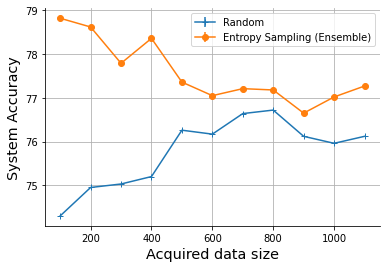

In [ ]:


#avgs_rand = [np.average([scores_oracle[triall] - scores_lime[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
#stds_rand = [np.std([scores_oracle[triall] -scores_lime[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
#plt.errorbar(list(range(1,len(teaching_sizes)+1)),  avgs_rand, yerr=stds_rand, label=f'random')
avgs_rand = [np.average([error_random_trials[triall][i]  for triall in range(MAX_TRIALS)]) for i in range(MAX_ROUNDS + 1)]
stds_rand = [np.std([error_random_trials[triall][i]  for triall in range(MAX_TRIALS)]) for i in range(MAX_ROUNDS + 1)]
plt.errorbar(data_sizes,  avgs_rand, yerr=stds_rand, marker = "+",  label=f'Random')
'''
avgs_rand = [np.average([error_confidence_rejector_trials[triall][i]  for triall in range(MAX_TRIALS)]) for i in range(MAX_ROUNDS + 1)]
stds_rand = [np.std([error_confidence_rejector_trials[triall][i]  for triall in range(MAX_TRIALS)]) for i in range(MAX_ROUNDS + 1)]
plt.errorbar(data_sizes,  avgs_rand, yerr=stds_rand, marker = "+",  label=f'Rejector')

avgs_rand = [np.average([error_confidence_trials[triall][i]  for triall in range(MAX_TRIALS)]) for i in range(MAX_ROUNDS+1)]
stds_rand = [np.std([error_confidence_trials[triall][i]  for triall in range(MAX_TRIALS)]) for i in range(MAX_ROUNDS+1)]
plt.errorbar(data_sizes,  avgs_rand, yerr=stds_rand, marker = "o",  label=f'Entropy Sampling')
'''
avgs_rand = [np.average([error_confidence_trials_LCE[triall][i]  for triall in range(MAX_TRIALS)]) for i in range(MAX_ROUNDS+1)]
stds_rand = [np.std([error_confidence_trials_LCE[triall][i]  for triall in range(MAX_TRIALS)]) for i in range(MAX_ROUNDS+1)]
plt.errorbar(data_sizes,  avgs_rand, yerr=stds_rand, marker = "o",  label=f'Entropy Sampling (Ensemble)')

#plt.errorbar(data_sizes,  error_confidence_rejector, yerr=[0]*len(error_confidence_rejector), marker = "+",  label=f'Rejector Uncertainty')
#plt.errorbar(data_sizes,  errors_LCE, yerr=[0]*len(errors_LCE), marker = "o",  label=f'LCE random')
#plt.errorbar(data_sizes,  errors_teaching, yerr=[0]*len(error_confidence_rejector), marker = "o",  label=f'Teaching')


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.grid()
plt.legend(fontsize='large')
plt.legend()
plt.ylabel('System Accuracy',  fontsize='x-large')
plt.xlabel('Acquired data size', fontsize='x-large')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
#plt.savefig("teaching_complexity_cifar10.pdf", dpi = 1000)
plt.show()

In [ ]:
# test on unlabeled and retrieve a score for each data point